In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd

# Function to build the generator model
def build_generator(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy')  # Compile generator
    return model

# Function to build the discriminator model
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])  # Compile discriminator
    return model

# Function to compile the GAN
def compile_gan(generator, discriminator):
    discriminator.trainable = False  # Ensure discriminator is not trainable within GAN
    gan_input = Input(shape=(100,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    return gan

# Function to generate real stock data using ARIMA or similar techniques
def generate_real_data(stock_symbol="SYNTH", n_periods=100):
    # For simplicity, let's assume random values for now
    prices = np.cumsum(np.random.randn(n_periods)) + 100  # Random walk
    dates = pd.date_range(start="2022-01-01", periods=n_periods)
    stock_data = pd.DataFrame({'Date': dates, 'Price': prices, 'Symbol': stock_symbol})
    return stock_data

# Training function for GAN
def train_gan(generator, discriminator, gan, epochs=500, batch_size=64, n_periods=100):
    real_data = generate_real_data(n_periods=n_periods).Price.values
    noise_dim = 100

    for epoch in range(epochs):
        # Generate noise and fake stock prices
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        generated_prices = generator.predict(noise)

        # Select a random batch of real stock prices
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_prices = real_data[idx].reshape(-1, 1)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_prices, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_prices, np.zeros((batch_size, 1)))

        # Train the generator via the GAN model
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}')

# Function to generate synthetic stock prices and save to CSV
def generate_synthetic_stock_prices(stock_symbol="SYNTH", n_samples=1000, output_file="synthetic_stock_prices.csv"):
    generator = build_generator(input_dim=100, output_dim=1)
    discriminator = build_discriminator(input_dim=1)
    gan = compile_gan(generator, discriminator)

    # Train the GAN
    train_gan(generator, discriminator, gan, n_periods=n_samples)

    # Generate new synthetic stock prices
    noise = np.random.normal(0, 1, (n_samples, 100))
    synthetic_prices = generator.predict(noise).reshape(-1)

    # Save to CSV
    dates = pd.date_range(start="2022-01-01", periods=n_samples)
    stock_data = pd.DataFrame({'Date': dates, 'Price': synthetic_prices, 'Symbol': stock_symbol})
    stock_data.to_csv(output_file, index=False)
    print(f'Synthetic stock prices saved to {output_file}')

# Running the prototype
generate_synthetic_stock_prices(stock_symbol="SYNTH", n_samples=1000, output_file="synthetic_stock_data.csv")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Epoch 0, D Loss Real: [array(7.398557, dtype=float32), array(0., dtype=float32)], D Loss Fake: [array(4.0317106, dtype=float32), array(0.4921875, dtype=float32)], G Loss: [array(4.0317106, dtype=float32), array(4.0317106, dtype=float32), array(4.0317106, dtype=float32), array(0.4921875, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Function to build the LSTM-based generator model
def build_generator(input_dim, timesteps=60, features=5):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Input noise (batch_size, input_dim)
    model.add(Dense(timesteps * features, activation='relu'))  # Ensure units match timesteps * features
    model.add(Reshape((timesteps, features)))  # Reshape to (batch_size, timesteps, features)
    model.add(LSTM(128, return_sequences=True))  # Keep return_sequences=True
    model.add(LSTM(64, return_sequences=True))  # Ensure output is 3D
    model.add(Dense(features, activation='linear'))  # Output for all features (open, high, low, close, volume)
    model.compile(optimizer=Adam(), loss='binary_crossentropy')  # Compile generator
    return model

# Function to build the RNN-based discriminator model
def build_discriminator(timesteps=60, features=5):
    model = Sequential()
    model.add(Input(shape=(timesteps, features)))  # Input as time-series data (batch_size, timesteps, features)
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64))
    model.add(LeakyReLU(0.2))  # Use negative_slope instead of alpha
    model.add(Dense(1, activation='sigmoid'))  # Output classification (real/fake)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])  # Compile discriminator
    return model

# Function to compile the GAN
def compile_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training

    gan_input = Input(shape=(100,))  # Input noise (batch_size, 100)
    generated_data = generator(gan_input)  # Generate data (batch_size, timesteps, features)

    print(f"Generated Data Shape (from Generator): {generated_data.shape}")  # Debug: shape check after generator

    gan_output = discriminator(generated_data)  # Discriminator processes generated data (3D)

    gan = Model(gan_input, gan_output)  # Full GAN model
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    return gan

# Function to generate real stock data for training
def generate_real_data(n_periods=60, n_features=5):
    # Generate random walk data for multiple features: open, high, low, close, volume
    np.random.seed(0)
    real_data = np.cumsum(np.random.randn(n_periods, n_features), axis=0) + 100
    return real_data

# Training GAN for generating stock data
def train_gan(generator, discriminator, gan, epochs=100, batch_size=64, timesteps=60, features=5):
    for epoch in range(epochs):
        # Generate real stock data (batch_size, timesteps, features)
        real_data = np.array([generate_real_data(n_periods=timesteps, n_features=features) for _ in range(batch_size)])
        print(f"Real Data Shape: {real_data.shape}")  # Debug: shape check for real data

        # Generate noise and fake stock prices (batch_size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_prices = generator.predict(noise)  # Generated data (batch_size, timesteps, features)
        print(f"Generated Prices Shape: {generated_prices.shape}")  # Debug: shape check for generated data

        # Ensure generated data is of correct shape before passing to discriminator
        assert generated_prices.shape == (batch_size, timesteps, features), \
            f"Generated prices shape is incorrect: {generated_prices.shape}, expected {(batch_size, timesteps, features)}"

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))  # Real data, label 1
        d_loss_fake = discriminator.train_on_batch(generated_prices, np.zeros((batch_size, 1)))  # Fake data, label 0

        # Train the generator via the GAN model
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Fake label should be 1 for GAN training

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}')

# Generate synthetic stock prices and save to CSV
def generate_synthetic_stock_data(n_samples=1000, timesteps=60, features=5, output_file="complex_synthetic_stock_data.csv"):
    generator = build_generator(input_dim=100, timesteps=timesteps, features=features)
    discriminator = build_discriminator(timesteps=timesteps, features=features)
    gan = compile_gan(generator, discriminator)

    # Train the GAN
    train_gan(generator, discriminator, gan, timesteps=timesteps, features=features)

    # Generate new synthetic stock prices
    noise = np.random.normal(0, 1, (n_samples, 100))
    synthetic_prices = generator.predict(noise)  # Shape (n_samples, timesteps, features)

    print(f"Synthetic Prices Shape: {synthetic_prices.shape}")  # Debug: shape check for synthetic data

    # Reshape generated data for saving to CSV (to be of shape (n_samples * timesteps, features))
    synthetic_prices = synthetic_prices.reshape((n_samples * timesteps, features))

    # Save to CSV
    dates = pd.date_range(start="2022-01-01", periods=n_samples * timesteps)
    stock_data = pd.DataFrame(synthetic_prices, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    stock_data['Date'] = dates
    stock_data.to_csv(output_file, index=False)
    print(f'Synthetic stock prices saved to {output_file}')

# Running the prototype
generate_synthetic_stock_data(n_samples=1000, output_file="complex_synthetic_stock_data.csv")


Generated Data Shape (from Generator): (None, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
Generated Prices Shape: (64, 60, 5)


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss Real: [array(0.6259666, dtype=float32), array(1., dtype=float32)], D Loss Fake: [array(0.6616838, dtype=float32), array(0.5, dtype=float32)], G Loss: [array(0.6616838, dtype=float32), array(0.6616838, dtype=float32), array(0.6616838, dtype=float32), array(0.5, dtype=float32)]
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Generated Prices Shape: (64, 60, 5)


Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Generated Prices Shape: (64, 60, 5)
Real Data Shape: (64, 60, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Genera

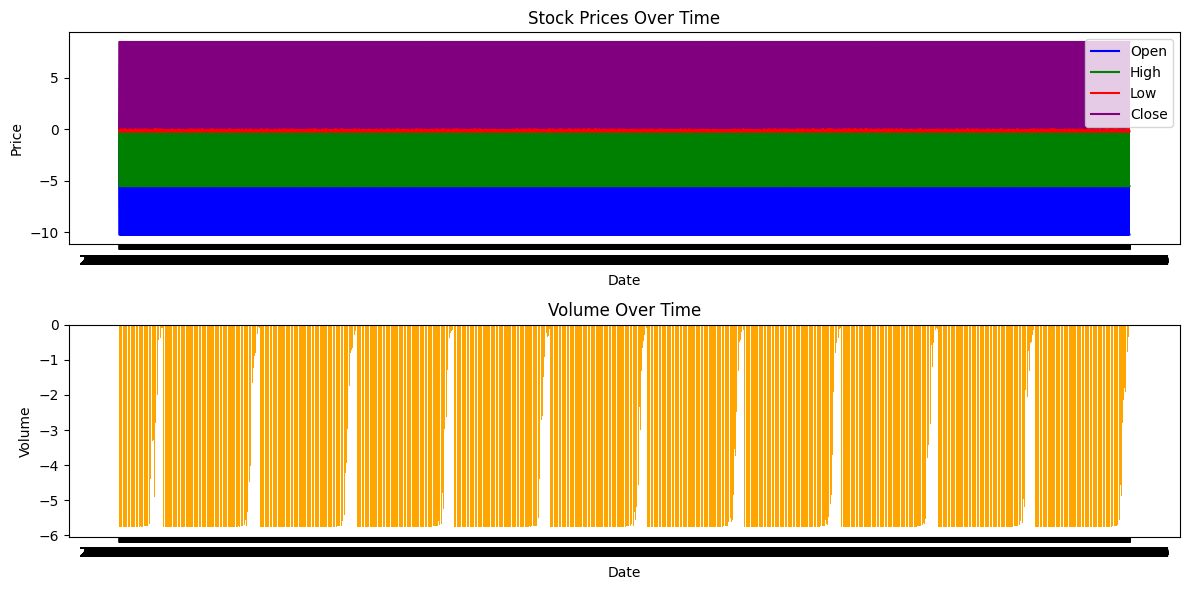

NameError: name 'correlation_matrix' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a Pandas DataFrame
file_path = '/content/complex_synthetic_stock_data.csv'
data = pd.read_csv(file_path)


# Visualizing the statistical properties using graphs
plt.figure(figsize=(12, 6))

# Plot a line chart for Open, High, Low, Close, and Volume
plt.subplot(2, 1, 1)
plt.plot(data['Date'], data['Open'], label='Open', color='blue')
plt.plot(data['Date'], data['High'], label='High', color='green')
plt.plot(data['Date'], data['Low'], label='Low', color='red')
plt.plot(data['Date'], data['Close'], label='Close', color='purple')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot a bar chart for Volume
plt.subplot(2, 1, 2)
plt.bar(data['Date'], data['Volume'], color='orange')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.tight_layout()
plt.show()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Stock Prices')
plt.show()

# Pairplot to visualize relationships between all columns
sns.pairplot(data)
plt.show()
